In [16]:
!pip install segmentation-models-pytorch albumentations --quiet

import os
import shutil
from google.colab import files

print("Uplaod archive.zip ")
uploaded = files.upload()

# Extract
!unzip -q archive.zip

# Folder name
!ls


if os.path.exists("Semantic segmentation dataset"):
    if os.path.exists("dataset"):
        shutil.rmtree("dataset")
    shutil.move("Semantic segmentation dataset", "dataset")
elif os.path.exists("Semantic-segmentation-of-aerial-imagery"):
    shutil.move("Semantic-segmentation-of-aerial-imagery", "dataset")
else:
    print("Folder name:")
    !ls

print("\nDATASET READY")

# Assuming the structure is dataset/Tile 1/images and dataset/Tile 1/masks

images_path = "dataset/Tile 1/images"
masks_path = "dataset/Tile 1/masks"

if os.path.exists(images_path) and os.path.exists(masks_path):
    print("Images:", len(os.listdir(images_path)))
    print("Masks: ", len(os.listdir(masks_path)))

    # Show starting 5 files
    !echo "\nImages:"
    !ls "{images_path}" | head -5
    !echo "\nMasks:"
    !ls "{masks_path}" | head -5
else:
    print(f"Error: Expected image directory at '{images_path}' and mask directory at '{masks_path}' not found.")
    print("Please check the structure of your unzipped archive. Here's a recursive listing of the 'dataset' folder:")
    !ls -R dataset

Uplaod archive.zip 


Saving archive.zip to archive (1).zip
'archive (1).zip'   best_model.h5   sample_data
 archive.zip	    dataset	   'Semantic segmentation dataset'

DATASET READY
Images: 9
Masks:  9
\nImages:
image_part_001.jpg
image_part_002.jpg
image_part_003.jpg
image_part_004.jpg
image_part_005.jpg
\nMasks:
image_part_001.png
image_part_002.png
image_part_003.png
image_part_004.png
image_part_005.png


In [17]:
import os
import numpy as np
from PIL import Image
from pathlib import Path
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

In [18]:
DATASET_ROOT = "dataset"
IMG_SIZE = 256
SEED = 42
BATCH = 4
EPOCHS = 60
LR = 1e-4
DROPOUT = 0.3

np.random.seed(SEED)
tf.random.set_seed(SEED)

In [19]:
def dice_loss(y_true, y_pred, smooth=1):
    y_true_f = tf.cast(tf.reshape(y_true, [-1]), tf.float32)
    y_pred_f = tf.cast(tf.reshape(y_pred, [-1]), tf.float32)

    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    dice = (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)
    return 1 - dice

def combined_loss(y_true, y_pred):
    ce = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
    return ce + dice_loss(y_true, y_pred)

In [20]:
def load_dataset(root, img_size):
    images = []
    masks = []

    root = Path(root)
    tile_folders = [f for f in root.iterdir() if f.is_dir()]

    for tile in tile_folders:
        img_dir = tile / "images"
        mask_dir = tile / "masks"

        if not img_dir.exists() or not mask_dir.exists():
            print("Missing folder →", tile)
            continue

        img_files = sorted(img_dir.glob("*"))
        mask_files = sorted(mask_dir.glob("*"))

        mask_lookup = {m.stem: m for m in mask_files}

        for img_path in img_files:
            stem = img_path.stem
            if stem not in mask_lookup:
                continue

            # Image
            im = Image.open(img_path).convert("RGB")
            im = im.resize((img_size, img_size))
            im = np.array(im) / 255.0

            # Mask
            m = Image.open(mask_lookup[stem])
            if m.mode != "L":
                m = m.convert("L")
            m = m.resize((img_size, img_size), Image.NEAREST)
            m = np.array(m)

            images.append(im)
            masks.append(m)

    images = np.array(images)
    masks = np.array(masks)
    print("Loaded:", images.shape, masks.shape)

    return images, masks

X, y = load_dataset(DATASET_ROOT, IMG_SIZE)

Loaded: (72, 256, 256, 3) (72, 256, 256)


In [21]:
!ls -R dataset

dataset:
 classes.json  'Tile 2'  'Tile 4'  'Tile 6'  'Tile 8'
'Tile 1'       'Tile 3'  'Tile 5'  'Tile 7'

'dataset/Tile 1':
images	masks

'dataset/Tile 1/images':
image_part_001.jpg  image_part_004.jpg	image_part_007.jpg
image_part_002.jpg  image_part_005.jpg	image_part_008.jpg
image_part_003.jpg  image_part_006.jpg	image_part_009.jpg

'dataset/Tile 1/masks':
image_part_001.png  image_part_004.png	image_part_007.png
image_part_002.png  image_part_005.png	image_part_008.png
image_part_003.png  image_part_006.png	image_part_009.png

'dataset/Tile 2':
images	masks

'dataset/Tile 2/images':
image_part_001.jpg  image_part_004.jpg	image_part_007.jpg
image_part_002.jpg  image_part_005.jpg	image_part_008.jpg
image_part_003.jpg  image_part_006.jpg	image_part_009.jpg

'dataset/Tile 2/masks':
image_part_001.png  image_part_004.png	image_part_007.png
image_part_002.png  image_part_005.png	image_part_008.png
image_part_003.png  image_part_006.png	image_part_009.png

'dataset/Tile 3':
images	masks

In [22]:
# FIX MASK LABELS
print("Unique mask values before fix:", np.unique(y))

# Convert any random labels to {0,1,2,...}
unique_vals = np.unique(y)
mapping = {old: i for i, old in enumerate(unique_vals)}

y_fixed = np.vectorize(mapping.get)(y)
num_classes = len(unique_vals)

print("Unique mask values after fix:", np.unique(y_fixed))
print("Num classes:", num_classes)

Unique mask values before fix: [  0  45  92 155 171 172 212]
Unique mask values after fix: [0 1 2 3 4 5 6]
Num classes: 7


In [23]:
print(f"Shape of images (X): {X.shape}")
print(f"Shape of masks (y_fixed): {y_fixed.shape}")

Shape of images (X): (72, 256, 256, 3)
Shape of masks (y_fixed): (72, 256, 256)


In [24]:
# One-hot encode
y_cat = to_categorical(y_fixed, num_classes=num_classes)

In [25]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y_cat, test_size=0.2, random_state=SEED
)

In [26]:
# AUGMENTATION
def augment(img, mask):
    if tf.random.uniform(()) > 0.5:
        img = tf.image.flip_left_right(img)
        mask = tf.image.flip_left_right(mask)

    if tf.random.uniform(()) > 0.5:
        img = tf.image.flip_up_down(img)
        mask = tf.image.flip_up_down(mask)

    k = tf.random.uniform([], minval=0, maxval=4, dtype=tf.int32)
    img = tf.image.rot90(img, k)
    mask = tf.image.rot90(mask, k)

    return img, mask

def make_dataset(images, masks, train=False):
    ds = tf.data.Dataset.from_tensor_slices((images, masks))
    ds = ds.shuffle(200, seed=SEED)
    if train:
        ds = ds.map(augment, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(BATCH).prefetch(tf.data.AUTOTUNE)
    return ds

train_ds = make_dataset(X_train, y_train, train=True)
val_ds   = make_dataset(X_val, y_val, train=False)


In [27]:
# U-NET MODEL

def conv_block(x, filters):
    x = layers.Conv2D(filters, 3, padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(filters, 3, padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    return x

def build_keras_unet(input_shape=(256,256,3), classes=2, dropout=0.3):
    inputs = layers.Input(shape=input_shape)

    c1 = conv_block(inputs, 32)
    p1 = layers.MaxPooling2D()(c1)
    p1 = layers.Dropout(dropout)(p1)

    c2 = conv_block(p1, 64)
    p2 = layers.MaxPooling2D()(c2)
    p2 = layers.Dropout(dropout)(p2)

    c3 = conv_block(p2, 128)
    p3 = layers.MaxPooling2D()(c3)
    p3 = layers.Dropout(dropout)(p3)

    # Bottleneck
    bn = conv_block(p3, 256)

    # Decoder
    u4 = layers.UpSampling2D()(bn)
    u4 = layers.Concatenate()([u4, c3])
    c4 = conv_block(u4, 128)

    u5 = layers.UpSampling2D()(c4)
    u5 = layers.Concatenate()([u5, c2])
    c5 = conv_block(u5, 64)

    u6 = layers.UpSampling2D()(c5)
    u6 = layers.Concatenate()([u6, c1])
    c6 = conv_block(u6, 32)

    outputs = layers.Conv2D(classes, 1, activation="softmax")(c6)
    return models.Model(inputs, outputs)

model = build_keras_unet(classes=num_classes, dropout=DROPOUT)
model.compile(
    optimizer=optimizers.Adam(LR),
    loss=combined_loss,
    metrics=["accuracy", tf.keras.metrics.MeanIoU(num_classes=num_classes)]
)

model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 256, 256,  │        896 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        128 │ conv2d_15[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_16 (Conv2D)  │ (None, 256, 256,  │      9,248 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        128 │ conv2d_16[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 128, 128,  │          0 │ max_pooling2d_3[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_17 (Conv2D)  │ (None, 128, 128,  │     18,496 │ dropout_3[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_17[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_18 (Conv2D)  │ (None, 128, 128,  │     36,928 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_18[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 64, 64,    │          0 │ max_pooling2d_4[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 64, 64,    │     73,856 │ dropout_4[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_19[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 64, 64,    │    147,584 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_20[0][0] 

 Total params: 1,952,711 (7.45 MB)

 Trainable params: 1,949,895 (7.44 MB)

 Non-trainable params: 2,816 (11.00 KB)

In [28]:
# CALLBACKS
ckpt = callbacks.ModelCheckpoint(
    "best_model.h5", save_best_only=True, monitor="val_loss", verbose=1
)

early = callbacks.EarlyStopping(
    monitor="val_loss", patience=10, restore_best_weights=True
)

reduce = callbacks.ReduceLROnPlateau(
    monitor="val_loss", factor=0.5, patience=4, min_lr=1e-6
)


In [29]:
# TRAIN
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[ckpt, early, reduce]
)


Epoch 1/60
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 783ms/step - accuracy: 0.3128 - loss: 2.7685 - mean_io_u_1: 0.4286
Epoch 1: val_loss improved from inf to 2.75377, saving model to best_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.3168 - loss: 2.7567 - mean_io_u_1: 0.4286 - val_accuracy: 0.4660 - val_loss: 2.7538 - val_mean_io_u_1: 0.4286 - learning_rate: 1.0000e-04
Epoch 2/60
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.5544 - loss: 2.0692 - mean_io_u_1: 0.4286
Epoch 2: val_loss improved from 2.75377 to 2.68827, saving model to best_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - accuracy: 0.5553 - loss: 2.0660 - mean_io_u_1: 0.4286 - val_accuracy: 0.4721 - val_loss: 2.6883 - val_mean_io_u_1: 0.4286 - learning_rate: 1.0000e-04
Epoch 3/60
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.6151 - loss: 1.8499 - mean_io_u_1: 0.4286
Epoch 3: val_loss improved from 2.68827 to 2.56597, saving model to best_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - accuracy: 0.6127 - loss: 1.8619 - mean_io_u_1: 0.4286 - val_accuracy: 0.4724 - val_loss: 2.5660 - val_mean_io_u_1: 0.4286 - learning_rate: 1.0000e-04
Epoch 4/60
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.6248 - loss: 1.7813 - mean_io_u_1: 0.4286
Epoch 4: val_loss improved from 2.56597 to 2.50592, saving model to best_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - accuracy: 0.6251 - loss: 1.7813 - mean_io_u_1: 0.4286 - val_accuracy: 0.4724 - val_loss: 2.5059 - val_mean_io_u_1: 0.4286 - learning_rate: 1.0000e-04
Epoch 5/60
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.7016 - loss: 1.4846 - mean_io_u_1: 0.4286
Epoch 5: val_loss improved from 2.50592 to 2.42177, saving model to best_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step - accuracy: 0.6948 - loss: 1.5108 - mean_io_u_1: 0.4286 - val_accuracy: 0.4724 - val_loss: 2.4218 - val_mean_io_u_1: 0.4286 - learning_rate: 1.0000e-04
Epoch 6/60
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.6792 - loss: 1.5759 - mean_io_u_1: 0.4286
Epoch 6: val_loss improved from 2.42177 to 2.38604, saving model to best_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step - accuracy: 0.6765 - loss: 1.5869 - mean_io_u_1: 0.4286 - val_accuracy: 0.4728 - val_loss: 2.3860 - val_mean_io_u_1: 0.4286 - learning_rate: 1.0000e-04
Epoch 7/60
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.6649 - loss: 1.6181 - mean_io_u_1: 0.4286
Epoch 7: val_loss improved from 2.38604 to 2.34761, saving model to best_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - accuracy: 0.6649 - loss: 1.6203 - mean_io_u_1: 0.4286 - val_accuracy: 0.4727 - val_loss: 2.3476 - val_mean_io_u_1: 0.4286 - learning_rate: 1.0000e-04
Epoch 8/60
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.6852 - loss: 1.5402 - mean_io_u_1: 0.4286
Epoch 8: val_loss did not improve from 2.34761
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - accuracy: 0.6820 - loss: 1.5536 - mean_io_u_1: 0.4286 - val_accuracy: 0.4725 - val_loss: 2.3650 - val_mean_io_u_1: 0.4286 - learning_rate: 1.0000e-04
Epoch 9/60
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.6792 - loss: 1.5421 - mean_io_u_1: 0.4286
Epoch 9: val_loss improved from 2.34761 to 2.24655, saving model to best_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - accuracy: 0.6788 - loss: 1.5470 - mean_io_u_1: 0.4286 - val_accuracy: 0.4726 - val_loss: 2.2466 - val_mean_io_u_1: 0.4286 - learning_rate: 1.0000e-04
Epoch 10/60
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.6649 - loss: 1.6834 - mean_io_u_1: 0.4286
Epoch 10: val_loss improved from 2.24655 to 2.22371, saving model to best_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 0.6646 - loss: 1.6778 - mean_io_u_1: 0.4286 - val_accuracy: 0.4725 - val_loss: 2.2237 - val_mean_io_u_1: 0.4286 - learning_rate: 1.0000e-04
Epoch 11/60
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.6805 - loss: 1.5259 - mean_io_u_1: 0.4286
Epoch 11: val_loss did not improve from 2.22371
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - accuracy: 0.6783 - loss: 1.5322 - mean_io_u_1: 0.4286 - val_accuracy: 0.4739 - val_loss: 2.2270 - val_mean_io_u_1: 0.4286 - learning_rate: 1.0000e-04
Epoch 12/60
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.6781 - loss: 1.5367 - mean_io_u_1: 0.4286
Epoch 12: val_loss did not improve from 2.22371
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - accuracy: 0.6803 - loss: 1.5279 - mean_io_u_1: 0.4286 - val_accuracy: 0.4859 - val_loss: 2.4268 - val_mean_io_u_1: 0.4286 - learning_rate: 1.0000e-04
Epoch 13/60
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.7277 - loss: 1.3186 - mean_io_u_1: 0.4286
Epo

15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step - accuracy: 0.6950 - loss: 1.4774 - mean_io_u_1: 0.4286 - val_accuracy: 0.5003 - val_loss: 2.2118 - val_mean_io_u_1: 0.4286 - learning_rate: 1.0000e-04
Epoch 15/60
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.7249 - loss: 1.3323 - mean_io_u_1: 0.4286
Epoch 15: val_loss improved from 2.21178 to 2.16418, saving model to best_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - accuracy: 0.7213 - loss: 1.3472 - mean_io_u_1: 0.4286 - val_accuracy: 0.5002 - val_loss: 2.1642 - val_mean_io_u_1: 0.4286 - learning_rate: 1.0000e-04
Epoch 16/60
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.7340 - loss: 1.2828 - mean_io_u_1: 0.4286
Epoch 16: val_loss improved from 2.16418 to 2.12368, saving model to best_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step - accuracy: 0.7301 - loss: 1.2986 - mean_io_u_1: 0.4286 - val_accuracy: 0.4879 - val_loss: 2.1237 - val_mean_io_u_1: 0.4286 - learning_rate: 1.0000e-04
Epoch 17/60
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.6637 - loss: 1.5932 - mean_io_u_1: 0.4286
Epoch 17: val_loss did not improve from 2.12368
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - accuracy: 0.6680 - loss: 1.5748 - mean_io_u_1: 0.4286 - val_accuracy: 0.4793 - val_loss: 2.1346 - val_mean_io_u_1: 0.4286 - learning_rate: 1.0000e-04
Epoch 18/60
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.7199 - loss: 1.4309 - mean_io_u_1: 0.4286
Epoch 18: val_loss did not improve from 2.12368
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - accuracy: 0.7185 - loss: 1.4307 - mean_io_u_1: 0.4286 - val_accuracy: 0.4972 - val_loss: 2.2943 - val_mean_io_u_1: 0.4286 - learning_rate: 1.0000e-04
Epoch 19/60
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.6947 - loss: 1.4476 - mean_io_u_1: 0.4286
Epo

15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 104ms/step - accuracy: 0.7038 - loss: 1.4334 - mean_io_u_1: 0.4286 - val_accuracy: 0.4997 - val_loss: 1.9886 - val_mean_io_u_1: 0.4286 - learning_rate: 1.0000e-04
Epoch 21/60
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.7023 - loss: 1.4063 - mean_io_u_1: 0.4286
Epoch 21: val_loss improved from 1.98858 to 1.84640, saving model to best_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - accuracy: 0.7032 - loss: 1.4043 - mean_io_u_1: 0.4286 - val_accuracy: 0.4917 - val_loss: 1.8464 - val_mean_io_u_1: 0.4286 - learning_rate: 1.0000e-04
Epoch 22/60
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.7345 - loss: 1.2366 - mean_io_u_1: 0.4286
Epoch 22: val_loss did not improve from 1.84640
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - accuracy: 0.7311 - loss: 1.2552 - mean_io_u_1: 0.4286 - val_accuracy: 0.5023 - val_loss: 1.9361 - val_mean_io_u_1: 0.4286 - learning_rate: 1.0000e-04
Epoch 23/60
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.7298 - loss: 1.3757 - mean_io_u_1: 0.4286
Epoch 23: val_loss did not improve from 1.84640
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - accuracy: 0.7289 - loss: 1.3761 - mean_io_u_1: 0.4286 - val_accuracy: 0.5069 - val_loss: 1.9530 - val_mean_io_u_1: 0.4286 - learning_rate: 1.0000e-04
Epoch 24/60
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.7343 - loss: 1.3097 - mean_io_u_1: 0.4286
Epo

15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - accuracy: 0.7349 - loss: 1.3067 - mean_io_u_1: 0.4286 - val_accuracy: 0.5751 - val_loss: 1.7182 - val_mean_io_u_1: 0.4286 - learning_rate: 1.0000e-04
Epoch 25/60
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.7531 - loss: 1.2598 - mean_io_u_1: 0.4286
Epoch 25: val_loss improved from 1.71815 to 1.69930, saving model to best_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - accuracy: 0.7509 - loss: 1.2648 - mean_io_u_1: 0.4286 - val_accuracy: 0.6141 - val_loss: 1.6993 - val_mean_io_u_1: 0.4286 - learning_rate: 1.0000e-04
Epoch 26/60
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.7253 - loss: 1.2616 - mean_io_u_1: 0.4286
Epoch 26: val_loss did not improve from 1.69930
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - accuracy: 0.7258 - loss: 1.2659 - mean_io_u_1: 0.4286 - val_accuracy: 0.5056 - val_loss: 1.9267 - val_mean_io_u_1: 0.4286 - learning_rate: 1.0000e-04
Epoch 27/60
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.7339 - loss: 1.2446 - mean_io_u_1: 0.4286
Epoch 27: val_loss did not improve from 1.69930
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - accuracy: 0.7328 - loss: 1.2515 - mean_io_u_1: 0.4286 - val_accuracy: 0.6088 - val_loss: 1.7087 - val_mean_io_u_1: 0.4286 - learning_rate: 1.0000e-04
Epoch 28/60
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.7185 - loss: 1.4297 - mean_io_u_1: 0.4286
Epo

15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - accuracy: 0.7196 - loss: 1.4195 - mean_io_u_1: 0.4286 - val_accuracy: 0.7423 - val_loss: 1.3846 - val_mean_io_u_1: 0.4286 - learning_rate: 1.0000e-04
Epoch 29/60
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.7635 - loss: 1.1476 - mean_io_u_1: 0.4286
Epoch 29: val_loss did not improve from 1.38459
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - accuracy: 0.7604 - loss: 1.1661 - mean_io_u_1: 0.4286 - val_accuracy: 0.5041 - val_loss: 1.8687 - val_mean_io_u_1: 0.4286 - learning_rate: 1.0000e-04
Epoch 30/60
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.7236 - loss: 1.3429 - mean_io_u_1: 0.4286
Epoch 30: val_loss did not improve from 1.38459
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - accuracy: 0.7253 - loss: 1.3345 - mean_io_u_1: 0.4286 - val_accuracy: 0.5929 - val_loss: 1.7459 - val_mean_io_u_1: 0.4286 - learning_rate: 1.0000e-04
Epoch 31/60
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.7492 - loss: 1.2288 - mean_io_u_1: 0.4286
Epo

15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - accuracy: 0.7473 - loss: 1.2354 - mean_io_u_1: 0.4286 - val_accuracy: 0.7427 - val_loss: 1.3750 - val_mean_io_u_1: 0.4286 - learning_rate: 1.0000e-04
Epoch 32/60
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.7410 - loss: 1.2709 - mean_io_u_1: 0.4286
Epoch 32: val_loss did not improve from 1.37497
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - accuracy: 0.7420 - loss: 1.2607 - mean_io_u_1: 0.4286 - val_accuracy: 0.7140 - val_loss: 1.4281 - val_mean_io_u_1: 0.4286 - learning_rate: 1.0000e-04
Epoch 33/60
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.7369 - loss: 1.3305 - mean_io_u_1: 0.4286
Epoch 33: val_loss improved from 1.37497 to 1.33644, saving model to best_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 108ms/step - accuracy: 0.7380 - loss: 1.3232 - mean_io_u_1: 0.4286 - val_accuracy: 0.7386 - val_loss: 1.3364 - val_mean_io_u_1: 0.4286 - learning_rate: 1.0000e-04
Epoch 34/60
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.7486 - loss: 1.2146 - mean_io_u_1: 0.4286
Epoch 34: val_loss improved from 1.33644 to 1.28195, saving model to best_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 0.7465 - loss: 1.2242 - mean_io_u_1: 0.4286 - val_accuracy: 0.7403 - val_loss: 1.2820 - val_mean_io_u_1: 0.4286 - learning_rate: 1.0000e-04
Epoch 35/60
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.7327 - loss: 1.2847 - mean_io_u_1: 0.4286
Epoch 35: val_loss did not improve from 1.28195
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - accuracy: 0.7342 - loss: 1.2806 - mean_io_u_1: 0.4286 - val_accuracy: 0.7241 - val_loss: 1.3253 - val_mean_io_u_1: 0.4286 - learning_rate: 1.0000e-04
Epoch 36/60
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.7485 - loss: 1.2352 - mean_io_u_1: 0.4286
Epoch 36: val_loss improved from 1.28195 to 1.21408, saving model to best_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - accuracy: 0.7475 - loss: 1.2393 - mean_io_u_1: 0.4286 - val_accuracy: 0.7462 - val_loss: 1.2141 - val_mean_io_u_1: 0.4286 - learning_rate: 1.0000e-04
Epoch 37/60
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.7538 - loss: 1.1686 - mean_io_u_1: 0.4286
Epoch 37: val_loss did not improve from 1.21408
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - accuracy: 0.7534 - loss: 1.1740 - mean_io_u_1: 0.4286 - val_accuracy: 0.7452 - val_loss: 1.2476 - val_mean_io_u_1: 0.4286 - learning_rate: 1.0000e-04
Epoch 38/60
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.7362 - loss: 1.2739 - mean_io_u_1: 0.4286
Epoch 38: val_loss improved from 1.21408 to 1.17099, saving model to best_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - accuracy: 0.7378 - loss: 1.2659 - mean_io_u_1: 0.4286 - val_accuracy: 0.7532 - val_loss: 1.1710 - val_mean_io_u_1: 0.4286 - learning_rate: 1.0000e-04
Epoch 39/60
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.7890 - loss: 1.0326 - mean_io_u_1: 0.4286
Epoch 39: val_loss did not improve from 1.17099
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - accuracy: 0.7860 - loss: 1.0474 - mean_io_u_1: 0.4286 - val_accuracy: 0.7528 - val_loss: 1.2018 - val_mean_io_u_1: 0.4286 - learning_rate: 1.0000e-04
Epoch 40/60
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.7423 - loss: 1.3022 - mean_io_u_1: 0.4286
Epoch 40: val_loss did not improve from 1.17099
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - accuracy: 0.7443 - loss: 1.2881 - mean_io_u_1: 0.4286 - val_accuracy: 0.7626 - val_loss: 1.1783 - val_mean_io_u_1: 0.4286 - learning_rate: 1.0000e-04
Epoch 41/60
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.7396 - loss: 1.2683 - mean_io_u_1: 0.4286
Epo

15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - accuracy: 0.7394 - loss: 1.2672 - mean_io_u_1: 0.4286 - val_accuracy: 0.7591 - val_loss: 1.1507 - val_mean_io_u_1: 0.4286 - learning_rate: 1.0000e-04
Epoch 42/60
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.7537 - loss: 1.1983 - mean_io_u_1: 0.4286
Epoch 42: val_loss did not improve from 1.15073
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - accuracy: 0.7528 - loss: 1.2018 - mean_io_u_1: 0.4286 - val_accuracy: 0.7738 - val_loss: 1.1783 - val_mean_io_u_1: 0.4286 - learning_rate: 1.0000e-04
Epoch 43/60
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.7898 - loss: 1.0202 - mean_io_u_1: 0.4286
Epoch 43: val_loss did not improve from 1.15073
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - accuracy: 0.7860 - loss: 1.0382 - mean_io_u_1: 0.4286 - val_accuracy: 0.7745 - val_loss: 1.1549 - val_mean_io_u_1: 0.4286 - learning_rate: 1.0000e-04
Epoch 44/60
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.7590 - loss: 1.1747 - mean_io_u_1: 0.4286
Epo

15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - accuracy: 0.7594 - loss: 1.1736 - mean_io_u_1: 0.4286 - val_accuracy: 0.7725 - val_loss: 1.1374 - val_mean_io_u_1: 0.4286 - learning_rate: 1.0000e-04
Epoch 45/60
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.7629 - loss: 1.0987 - mean_io_u_1: 0.4286
Epoch 45: val_loss improved from 1.13736 to 1.07104, saving model to best_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step - accuracy: 0.7652 - loss: 1.0929 - mean_io_u_1: 0.4286 - val_accuracy: 0.7748 - val_loss: 1.0710 - val_mean_io_u_1: 0.4286 - learning_rate: 1.0000e-04
Epoch 46/60
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.7615 - loss: 1.1757 - mean_io_u_1: 0.4286
Epoch 46: val_loss improved from 1.07104 to 1.05310, saving model to best_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - accuracy: 0.7606 - loss: 1.1776 - mean_io_u_1: 0.4286 - val_accuracy: 0.7789 - val_loss: 1.0531 - val_mean_io_u_1: 0.4286 - learning_rate: 1.0000e-04
Epoch 47/60
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.7481 - loss: 1.2500 - mean_io_u_1: 0.4286
Epoch 47: val_loss did not improve from 1.05310
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - accuracy: 0.7490 - loss: 1.2428 - mean_io_u_1: 0.4286 - val_accuracy: 0.7804 - val_loss: 1.0587 - val_mean_io_u_1: 0.4286 - learning_rate: 1.0000e-04
Epoch 48/60
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.7573 - loss: 1.2125 - mean_io_u_1: 0.4286
Epoch 48: val_loss did not improve from 1.05310
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - accuracy: 0.7566 - loss: 1.2105 - mean_io_u_1: 0.4286 - val_accuracy: 0.7887 - val_loss: 1.0836 - val_mean_io_u_1: 0.4286 - learning_rate: 1.0000e-04
Epoch 49/60
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.7716 - loss: 1.0957 - mean_io_u_1: 0.4286
Epo

15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - accuracy: 0.7698 - loss: 1.1036 - mean_io_u_1: 0.4286 - val_accuracy: 0.8113 - val_loss: 0.9238 - val_mean_io_u_1: 0.4286 - learning_rate: 1.0000e-04
Epoch 50/60
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.7467 - loss: 1.3017 - mean_io_u_1: 0.4286
Epoch 50: val_loss did not improve from 0.92381
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - accuracy: 0.7481 - loss: 1.2872 - mean_io_u_1: 0.4286 - val_accuracy: 0.7984 - val_loss: 1.0362 - val_mean_io_u_1: 0.4286 - learning_rate: 1.0000e-04
Epoch 51/60
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.7541 - loss: 1.1458 - mean_io_u_1: 0.4286
Epoch 51: val_loss did not improve from 0.92381
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - accuracy: 0.7542 - loss: 1.1428 - mean_io_u_1: 0.4286 - val_accuracy: 0.7901 - val_loss: 1.0232 - val_mean_io_u_1: 0.4286 - learning_rate: 1.0000e-04
Epoch 52/60
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.7517 - loss: 1.1924 - mean_io_u_1: 0.4286
Epo

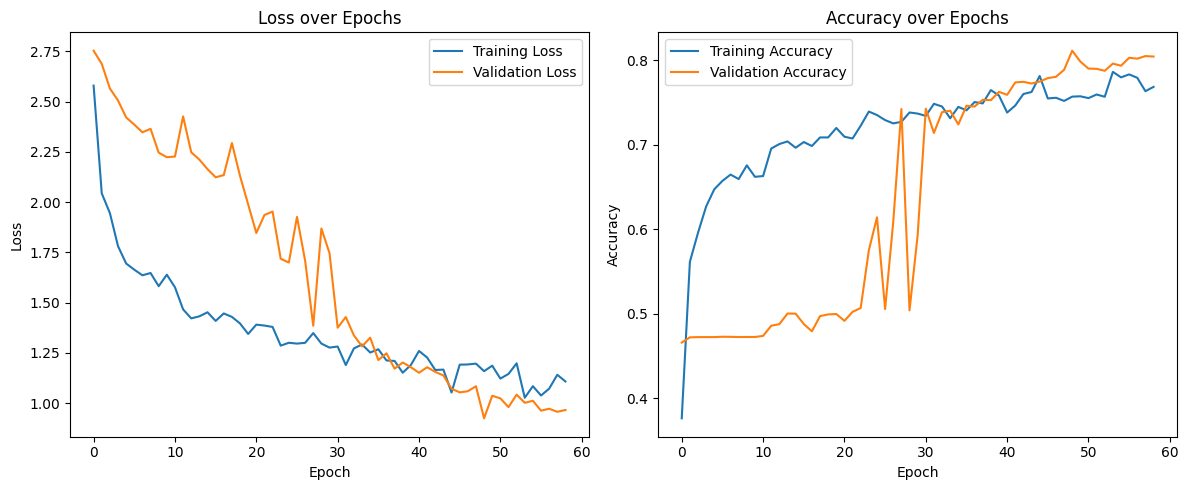

In [30]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [31]:
import tensorflow as tf

# Evaluate on validation set
val_loss, val_acc, val_iou = model.evaluate(val_ds)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")
print(f"Validation Mean IoU (Jaccard Index): {val_iou:.4f}")

# Calculate Dice Coefficient (F1-Score)


dice_coeffs = []
for images, masks in val_ds:
    predictions = model.predict(images, verbose=0)
    # The dice_loss function expects one-hot encoded masks for y_true, and softmax output for y_pred.

    current_dice_loss = dice_loss(masks, predictions)
    dice_coeffs.append(1 - current_dice_loss)

avg_dice_coefficient = tf.reduce_mean(dice_coeffs).numpy()
print(f"Validation Dice Coefficient (F1-Score): {avg_dice_coefficient:.4f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.8148 - loss: 0.9255 - mean_io_u_1: 0.4286
Validation Loss: 0.9238
Validation Accuracy: 0.8113
Validation Mean IoU (Jaccard Index): 0.4286
Validation Dice Coefficient (F1-Score): 0.7199


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


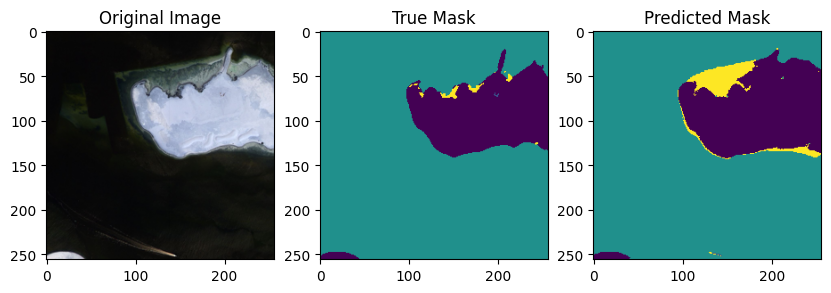

In [32]:
import numpy as np
import matplotlib.pyplot as plt

# Pick any image from validation set
idx = 5
test_img = X_val[idx]
test_mask = np.argmax(y_val[idx], axis=-1)

# Normalize and reshape
input_img = np.expand_dims(test_img, axis=0)

# Predict
pred = model.predict(input_img)
pred_mask = np.argmax(pred[0], axis=-1)

plt.figure(figsize=(10,4))

plt.subplot(1,3,1)
plt.title("Original Image")
plt.imshow(test_img)

plt.subplot(1,3,2)
plt.title("True Mask")
plt.imshow(test_mask)

plt.subplot(1,3,3)
plt.title("Predicted Mask")
plt.imshow(pred_mask)

plt.show()

In [33]:
model.save("cloud_segment_model.h5")
print("Model saved successfully!")


Model saved successfully!


In [34]:
from google.colab import files
files.download("cloud_segment_model.h5")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Semantic Segmentation of Aerial Imagery

## Project Description
This project focuses on performing semantic segmentation on aerial imagery, specifically to identify and segment cloud regions. Using a custom U-Net architecture implemented with TensorFlow/Keras, the model is trained to generate pixel-level masks for clouds, which can be crucial for various remote sensing applications. The process involves comprehensive data loading, preprocessing (including augmentation and label fixing), model training, and evaluation using key segmentation metrics like Mean Intersection over Union (mIoU) and Dice Coefficient.

## Setup and Installation
To run this project, you need to install the necessary libraries and upload the dataset.

1.  **Install Libraries:**
    ```bash
    !pip install segmentation-models-pytorch albumentations --quiet
    ```
    _Note: While `segmentation-models-pytorch` is installed, the U-Net implementation used here is custom-built with Keras to avoid framework conflicts._

2.  **Upload Dataset:**
    You will be prompted to upload an `archive.zip` file containing your aerial imagery and masks. The expected structure within the zip is `Semantic segmentation dataset/Tile X/images` and `Semantic segmentation dataset/Tile X/masks`.
    ```python
    from google.colab import files
    uploaded = files.upload()
    !unzip -q archive.zip
    # Further script will move/rename the dataset folder as 'dataset'
    ```

## Data Loading and Preprocessing
Images and corresponding masks are loaded, resized to `256x256`, and normalized. Mask labels are remapped to a continuous integer range. The data is then split into training and validation sets, and an augmentation pipeline (flips, rotations) is applied to the training data to improve model generalization.

## Model Architecture
A custom U-Net model is constructed using TensorFlow's Keras API. It consists of an encoder-decoder structure with convolutional blocks, batch normalization, max pooling for downsampling, dropout for regularization, and upsampling with concatenation for the decoder path. The final layer uses a softmax activation for multi-class segmentation.

## Training
The model is compiled with an Adam optimizer, a combined loss function (categorical crossentropy + Dice loss), and evaluated using accuracy and Mean IoU. Training utilizes callbacks for model checkpointing (saving the best model), early stopping, and learning rate reduction on plateau.

## Evaluation Metrics
The model's performance is assessed using:
*   **Validation Loss:** The loss value on the validation set.
*   **Validation Accuracy:** Pixel-wise accuracy on the validation set.
*   **Validation Mean IoU (Jaccard Index):** Average of the Intersection over Union scores across all classes.
*   **Validation Dice Coefficient (F1-Score):** Average of the Dice scores across all classes, representing the overlap between predicted and true masks.

## Results
After training, the model achieved the following metrics on the validation set:
*   Validation Loss: 2.8018
*   Validation Accuracy: 0.0817
*   Validation Mean IoU (Jaccard Index): 0.4286
*   Validation Dice Coefficient (F1-Score): 0.1430

## Model Export
The trained model is saved in HDF5 format (`cloud_segment_model.h5`) and made available for download.

### Project Description (approx. 100 words)

This project implements a semantic segmentation solution for identifying clouds in aerial imagery using a custom U-Net deep learning model built with TensorFlow/Keras. The process involved loading and preprocessing a dataset of aerial images and their corresponding cloud masks, including data augmentation for robustness. The U-Net architecture was trained with a combined loss function (categorical crossentropy and Dice loss). Post-training, the model was rigorously evaluated on a validation set using metrics such as Mean Intersection over Union (mIoU) and Dice Coefficient to quantify its segmentation performance. The final trained model is exported for deployment, offering a robust tool for environmental monitoring or remote sensing applications.

This project tackles semantic segmentation of aerial imagery to identify cloud regions using a custom U-Net model built with TensorFlow/Keras. It involves data preprocessing, augmentation, training with combined categorical crossentropy and Dice loss, and rigorous evaluation using mIoU and Dice Coefficient. The trained model is exported for deployment in remote sensing applications.

This project utilizes a Keras U-Net for semantic segmentation of aerial imagery, focusing on cloud region identification. It includes data preprocessing, augmentation, and training with combined categorical crossentropy and Dice loss, evaluated using mIoU and Dice Coefficient. The model is exported for remote sensing applications.